# Clustering
### Author: Adam Johnson
### UH ID: 2031383

In [40]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [4]:
data_dir = Path("datasets")

json_files = [
    "dblp-ref-0.json",
    "dblp-ref-1.json",
    "dblp-ref-2.json",
    "dblp-ref-3.json"
]

data = []
for jf in json_files:
    with open(data_dir / jf, "r") as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)
print("Raw shape:", df.shape)

Raw shape: (3079007, 8)


In [5]:
MIN_PAPERS_PER_VENUE = 1000

df["title"] = df["title"].fillna("").astype(str).str.strip()
df["venue"] = df["venue"].fillna("").astype(str).str.strip()

mask_valid = df["title"].astype(bool) & df["venue"].astype(bool)
df_clean = df[mask_valid].copy()
print("After dropping empty title/venue:", df_clean.shape)

mask_generic = (
    df_clean["venue"].str.contains(r"\barxiv\b", case=False, na=False) |
    df_clean["venue"].str.contains(r"\bcorr\b", case=False, na=False)
)
df_clean = df_clean[~mask_generic].copy()
print("After removing generic venues (arXiv/CoRR):", df_clean.shape)

venue_counts = df_clean["venue"].value_counts()
valid_venues = venue_counts[venue_counts > MIN_PAPERS_PER_VENUE].index
df_venues = df_clean[df_clean["venue"].isin(valid_venues)].copy()

venue_df = (
    df_venues
    .groupby("venue")
    .agg(
        n_papers=("id", "count"),
        titles_concat=("title", lambda x: " ".join(x))
    )
    .reset_index()
)

print("Number of venues with > {} papers: {}".format(
    MIN_PAPERS_PER_VENUE, venue_df.shape[0]
))

After dropping empty title/venue: (2572308, 8)
After removing generic venues (arXiv/CoRR): (2523749, 8)
Number of venues with > 1000 papers: 637


In [6]:
MAX_TFIDF_FEATURES = 1000
N_PCA_COMPONENTS = 50 

tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_TFIDF_FEATURES,
    stop_words="english"
)

X_tfidf_raw = tfidf_vectorizer.fit_transform(venue_df["titles_concat"])
X_tfidf_raw_dense = X_tfidf_raw.toarray()
print("TF-IDF raw shape:", X_tfidf_raw_dense.shape)

max_components = min(
    N_PCA_COMPONENTS,
    X_tfidf_raw_dense.shape[0],
    X_tfidf_raw_dense.shape[1]
)
pca_highdim = PCA(n_components=max_components, random_state=0)
X_pca = pca_highdim.fit_transform(X_tfidf_raw_dense)
print("PCA ({} comps) shape:".format(max_components), X_pca.shape)

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
print("PCA scaled shape:", X_pca_scaled.shape)

pca_2d = PCA(n_components=2, random_state=0)
X_plot_2d = pca_2d.fit_transform(X_tfidf_raw_dense)

TF-IDF raw shape: (637, 1000)
PCA (50 comps) shape: (637, 50)
PCA scaled shape: (637, 50)


In [7]:
def compute_sse(x, y_pred):
    # x is the array of data, x.shape=(numbe of data points, number of attributes)
    # y_pred is the array of cluster indices of all data points, len(y_pred)=number of data points
    x = np.asarray(x)
    y_pred = np.asarray(y_pred)

    N = x.shape[0]
    sse = 0.0

    for c in np.unique(y_pred):
        cluster_points = x[y_pred == c]

        centroid = cluster_points.mean(axis=0)

        sse += np.sum((cluster_points - centroid) ** 2)

    sse /= N
    return sse

In [8]:
feature_sets = {
    "tfidf_raw": X_tfidf_raw_dense,
    "tfidf_pca": X_pca,
    "tfidf_pca_scaled": X_pca_scaled,
}

kmeans_compare_10 = []
for name, X in feature_sets.items():
    n_samples = X.shape[0]
    k = 10
    if n_samples <= k:
        print(f"Skipping KMeans k=10 on {name}: n_samples={n_samples} <= k")
        continue

    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X)

    sse = km.inertia_
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else np.nan

    kmeans_compare_10.append({
        "feature_set": name,
        "k": k,
        "sse": sse,
        "silhouette": sil,
    })

kmeans_compare_10_df = pd.DataFrame(kmeans_compare_10)
print("\nKMeans (k=10) comparison across feature sets:")
print(kmeans_compare_10_df)


KMeans (k=10) comparison across feature sets:
        feature_set   k           sse  silhouette
0         tfidf_raw  10    291.689694    0.117158
1         tfidf_pca  10    202.835753    0.163523
2  tfidf_pca_scaled  10  27054.610512    0.019638



KMeans on TFIDF_PCA_scaled (multiple k):
      k           sse  silhouette
0     3  30723.675060   -0.067298
1     5  29762.233372   -0.053102
2    10  27054.610512    0.019638
3    20  22036.951730    0.133123
4    30  17489.184351    0.189084
5    40  13555.916565    0.259897
6    50  10544.006059    0.307103
7    75   7351.436197    0.321061
8   100   5916.349368    0.297704
9   150   4073.481849    0.281489
10  200   2900.849487    0.265245

Elbow method suggests k=50 (on SSE curve)


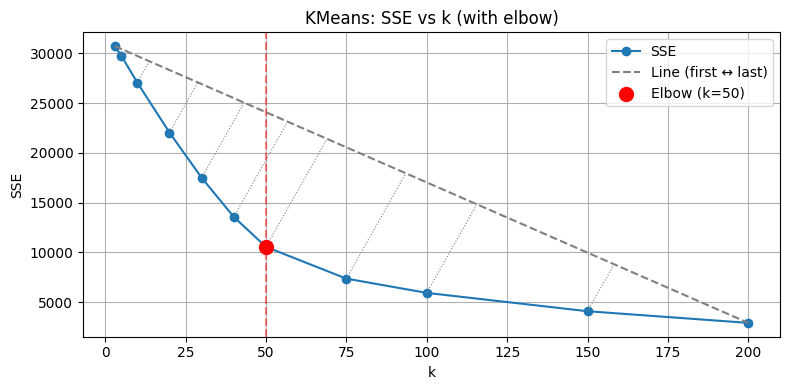

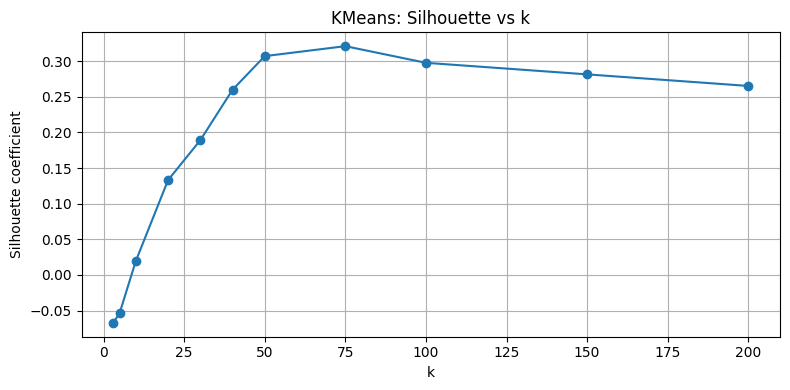


Best KMeans k (by silhouette): 75


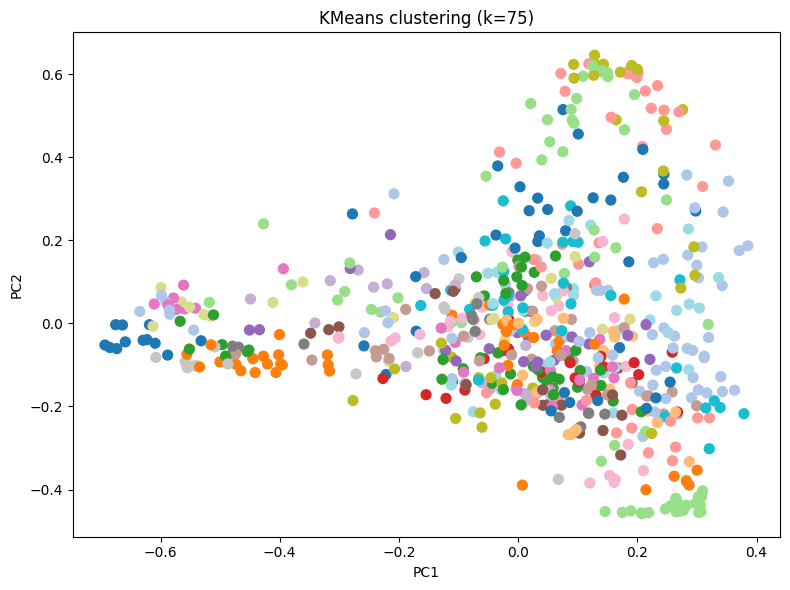

Top-3 k from KMeans (by silhouette): [75, 50, 100]


In [30]:
k_values = [3, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]
kmeans_results = []

for k in k_values:
    if X_pca_scaled.shape[0] <= k:
        print(f"Skipping KMeans k={k}: n_samples={X_pca_scaled.shape[0]} <= k")
        continue

    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X_pca_scaled)
    sse = km.inertia_
    sil = silhouette_score(X_pca_scaled, labels) if len(np.unique(labels)) > 1 else np.nan

    kmeans_results.append({
        "k": k,
        "sse": sse,
        "silhouette": sil,
    })

kmeans_results_df = pd.DataFrame(kmeans_results)
print("\nKMeans on TFIDF_PCA_scaled (multiple k):")
print(kmeans_results_df)


elbow_k = None
elbow_sse = None

k_arr = kmeans_results_df["k"].values.astype(float)
sse_arr = kmeans_results_df["sse"].values.astype(float)

if len(kmeans_results_df) >= 3:
    x1, y1 = k_arr[0], sse_arr[0]
    x2, y2 = k_arr[-1], sse_arr[-1]

    numerator = np.abs((y2 - y1) * k_arr - (x2 - x1) * sse_arr + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    distances = numerator / denominator

    elbow_idx = np.argmax(distances)
    elbow_k = int(k_arr[elbow_idx])
    elbow_sse = sse_arr[elbow_idx]

    print(f"\nElbow method suggests k={elbow_k} (on SSE curve)")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(kmeans_results_df["k"], kmeans_results_df["sse"], marker="o", label="SSE")

if len(k_arr) >= 2:
    x1, y1 = k_arr[0], sse_arr[0]
    x2, y2 = k_arr[-1], sse_arr[-1]
    ax.plot([x1, x2], [y1, y2], linestyle="--", color="gray", label="Line (first ↔ last)")

    fig.canvas.draw()

    p1_disp = ax.transData.transform((x1, y1))
    p2_disp = ax.transData.transform((x2, y2))
    dx_disp = p2_disp[0] - p1_disp[0]
    dy_disp = p2_disp[1] - p1_disp[1]
    denom_disp = dx_disp * dx_disp + dy_disp * dy_disp

    if denom_disp != 0:
        for x0, y0 in zip(k_arr, sse_arr):
            p_disp = ax.transData.transform((x0, y0))

            t = ((p_disp[0] - p1_disp[0]) * dx_disp +
                 (p_disp[1] - p1_disp[1]) * dy_disp) / denom_disp
            proj_disp_x = p1_disp[0] + t * dx_disp
            proj_disp_y = p1_disp[1] + t * dy_disp

            proj_data_x, proj_data_y = ax.transData.inverted().transform((proj_disp_x, proj_disp_y))

            ax.plot(
                [x0, proj_data_x],
                [y0, proj_data_y],
                linestyle=":",
                color="gray",
                linewidth=0.8
            )

if elbow_k is not None:
    ax.scatter([elbow_k], [elbow_sse], s=100, color="red", zorder=5, label=f"Elbow (k={elbow_k})")
    ax.axvline(elbow_k, linestyle="--", color="red", alpha=0.5)

ax.set_xlabel("k")
ax.set_ylabel("SSE")
ax.set_title("KMeans: SSE vs k (with elbow)")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(kmeans_results_df["k"], kmeans_results_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette coefficient")
plt.title("KMeans: Silhouette vs k")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_row = kmeans_results_df.sort_values("silhouette", ascending=False).iloc[0]
best_k_kmeans = int(best_k_row["k"])
print("\nBest KMeans k (by silhouette):", best_k_kmeans)

best_kmeans = KMeans(n_clusters=best_k_kmeans, random_state=0, n_init=10)
kmeans_best_labels = best_kmeans.fit_predict(X_pca_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_plot_2d[:, 0], X_plot_2d[:, 1], c=kmeans_best_labels, cmap="tab20", s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans clustering (k={best_k_kmeans})")
plt.tight_layout()
plt.show()

top3_k_from_kmeans = (
    kmeans_results_df
    .sort_values("silhouette", ascending=False)["k"]
    .head(3)
    .tolist()
)
print("Top-3 k from KMeans (by silhouette):", top3_k_from_kmeans)



Hierarchical clustering results (summary):
  linkage   k  distance_threshold        sse  silhouette
0  single   3            8.356460  49.541150    0.169639
1  single   5            8.021007  48.538062    0.151312
2  single  10            7.426337  46.615097    0.124929
3  single  20            6.775326  43.387719    0.068903
4  single  30            6.233399  40.952238    0.051244

Hierarchical clustering on top-3 KMeans ks:
     linkage    k  distance_threshold        sse  silhouette
28   average   50            8.780037  23.083511    0.218276
17  complete   50           11.218176  20.008559    0.243079
6     single   50            5.791415  38.425245   -0.056642
39      ward   50           19.872915  17.012891    0.293162
29   average   75            7.594064  14.682647    0.291343
18  complete   75            9.418156  12.566673    0.308625
7     single   75            5.239662  31.782248   -0.046591
40      ward   75           12.755355  11.581912    0.323603
30   average  100   

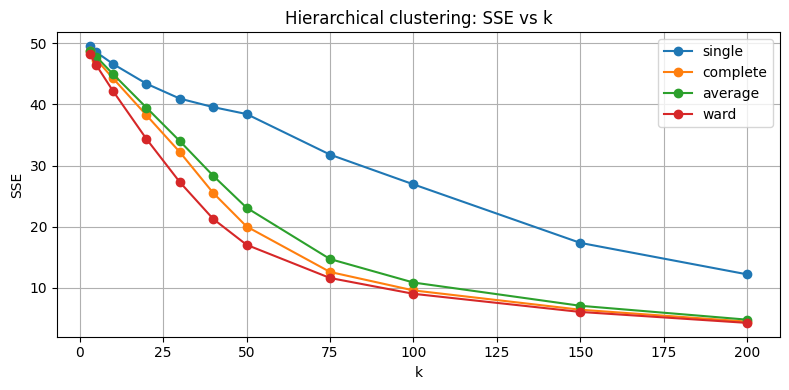

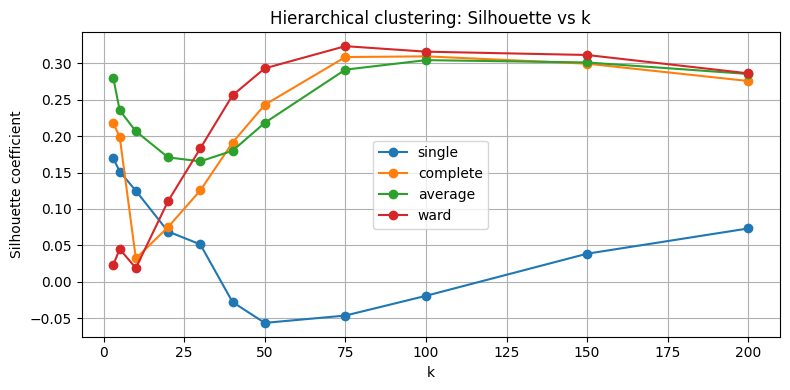

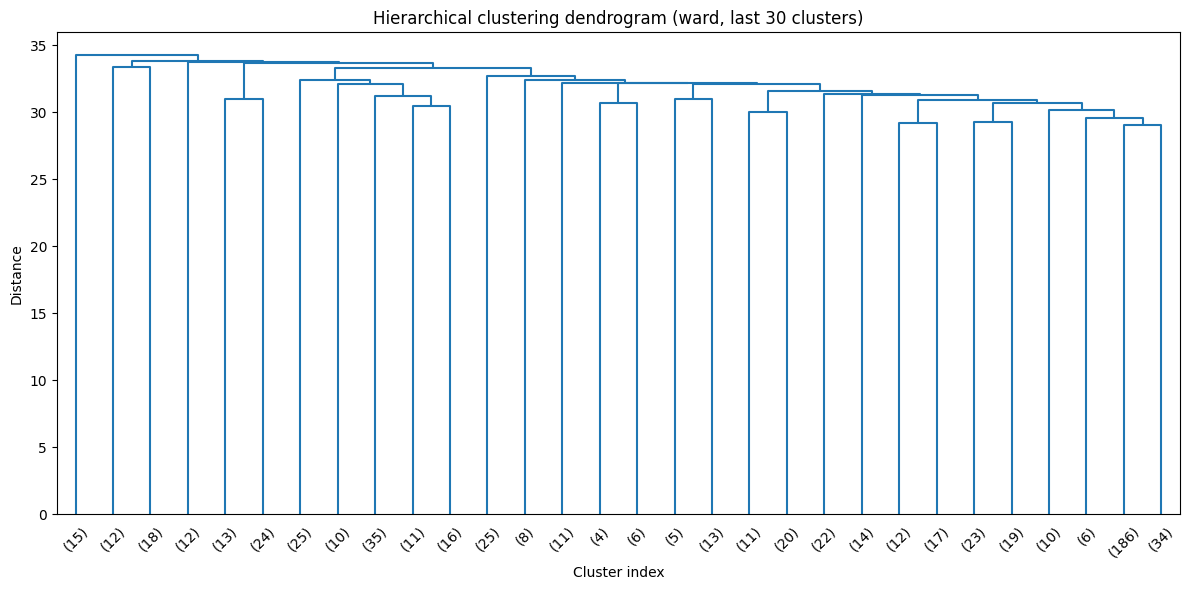


Best hierarchical clustering (by silhouette): linkage=ward, k=75


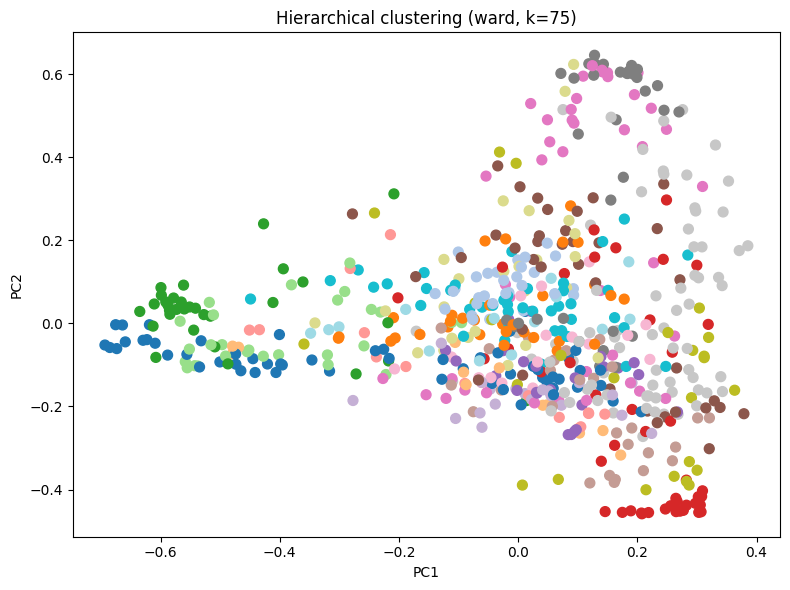

In [34]:
hier_methods = ["single", "complete", "average", "ward"]
Z_dict = {}
n_samples = X_pca_scaled.shape[0]

for method in hier_methods:
    if method == "ward":
        Z = linkage(X_pca_scaled, method=method)
    else:
        Z = linkage(X_pca_scaled, method=method, metric="euclidean")
    Z_dict[method] = Z

hier_results = []

for method, Z in Z_dict.items():
    distances = Z[:, 2]

    for k in k_values:
        if k <= 1 or k >= n_samples:
            continue

        labels = fcluster(Z, t=k, criterion="maxclust")
        labels_zero = labels - 1

        sse = compute_sse(X_pca_scaled, labels_zero)
        sil = (
            silhouette_score(X_pca_scaled, labels_zero)
            if len(np.unique(labels_zero)) > 1
            else np.nan
        )

        threshold_idx = n_samples - k - 1
        if 0 <= threshold_idx < len(distances):
            dist_th = distances[threshold_idx]
        else:
            dist_th = np.nan

        hier_results.append({
            "linkage": method,
            "k": k,
            "distance_threshold": dist_th,
            "sse": sse,
            "silhouette": sil,
        })

hier_results_df = pd.DataFrame(hier_results)
print("\nHierarchical clustering results (summary):")
print(hier_results_df.head())

hier_results_topk = (
    hier_results_df[hier_results_df["k"].isin(top3_k_from_kmeans)]
    .sort_values(["k", "linkage"])
)
print("\nHierarchical clustering on top-3 KMeans ks:")
print(hier_results_topk)

plt.figure(figsize=(8, 4))
for method in hier_methods:
    df_m = hier_results_df[hier_results_df["linkage"] == method].sort_values("k")
    plt.plot(df_m["k"], df_m["sse"], marker="o", label=method)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Hierarchical clustering: SSE vs k")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
for method in hier_methods:
    df_m = hier_results_df[hier_results_df["linkage"] == method].sort_values("k")
    plt.plot(df_m["k"], df_m["silhouette"], marker="o", label=method)
plt.xlabel("k")
plt.ylabel("Silhouette coefficient")
plt.title("Hierarchical clustering: Silhouette vs k")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
dendrogram(
    Z_dict["ward"],
    truncate_mode="lastp",
    p=30,
    show_leaf_counts=True,
)
plt.title("Hierarchical clustering dendrogram (ward, last 30 clusters)")
plt.xlabel("Cluster index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

best_hier_row = hier_results_df.sort_values("silhouette", ascending=False).iloc[0]
best_linkage = best_hier_row["linkage"]
best_k_hier = int(best_hier_row["k"])
print(
    "\nBest hierarchical clustering (by silhouette): "
    f"linkage={best_linkage}, k={best_k_hier}"
)

best_Z = Z_dict[best_linkage]
best_labels_hier = fcluster(best_Z, t=best_k_hier, criterion="maxclust") - 1

plt.figure(figsize=(8, 6))
plt.scatter(X_plot_2d[:, 0], X_plot_2d[:, 1], c=best_labels_hier, cmap="tab20", s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Hierarchical clustering ({best_linkage}, k={best_k_hier})")
plt.tight_layout()
plt.show()


DBSCAN results:
     eps  min_samples  n_clusters  n_noise  frac_clustered        sse  \
0    2.0            3          27      504        0.208791   2.050860   
1    2.0            4          14      552        0.133438   2.154240   
2    2.0            5           6      590        0.073783   2.237792   
3    2.0            7           2      619        0.028257   2.093117   
4    2.0           10           0      637        0.000000        NaN   
5    3.0            3          44      305        0.521193   7.861679   
6    3.0            4          31      359        0.436421   7.208428   
7    3.0            5          19      427        0.329670   7.963371   
8    3.0            7           9      504        0.208791   8.256805   
9    3.0           10           3      569        0.106750   9.146863   
10   4.0            3          42      161        0.747253  17.868303   
11   4.0            4          32      205        0.678179  17.466678   
12   4.0            5          24 

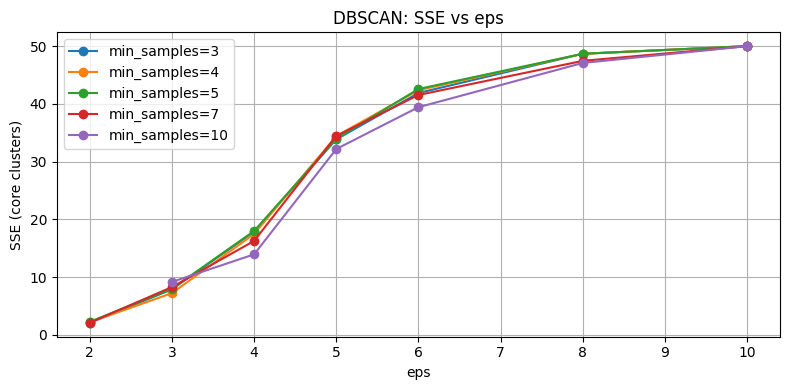

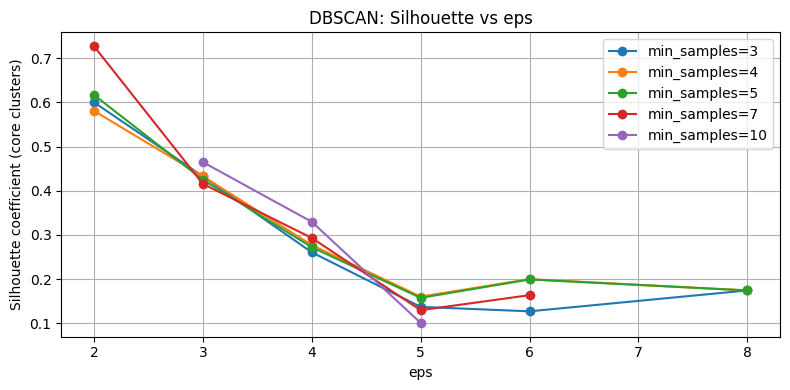

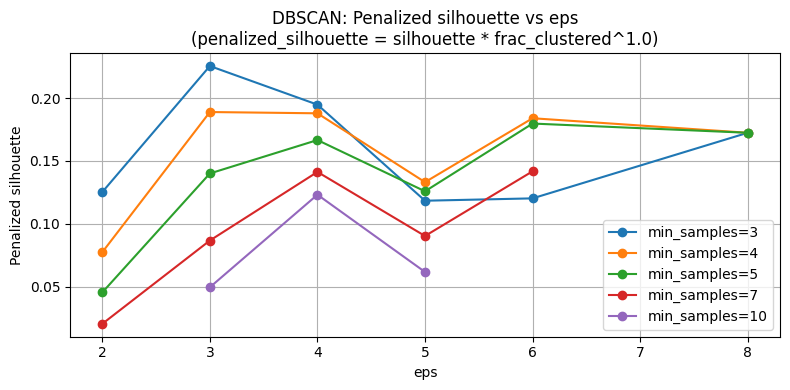


Best DBSCAN (by penalized silhouette): eps=3.0, min_samples=3
  raw silhouette=0.4326, frac_clustered=0.5212, penalized_silhouette=0.2255


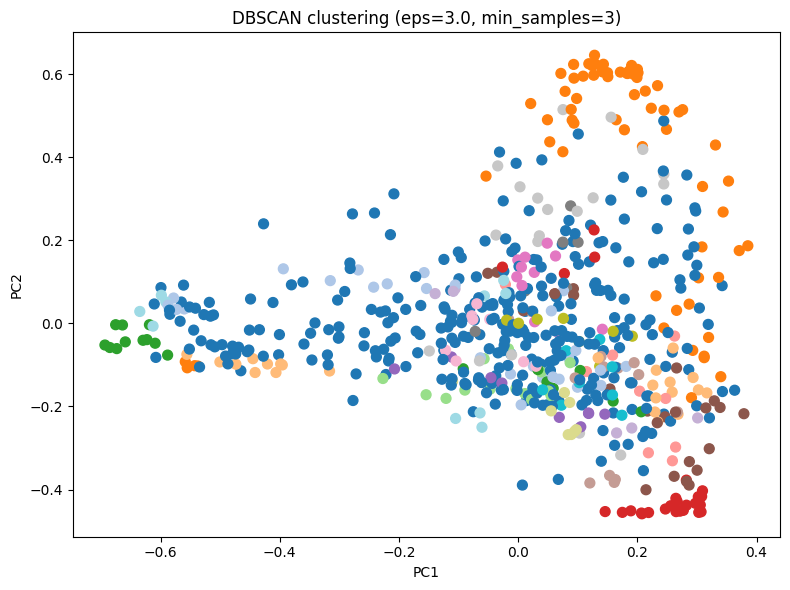

In [35]:
eps_values = [2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]
min_samples_values = [3, 4, 5, 7, 10]

alpha_penalty = 1.0

N = X_pca_scaled.shape[0]

dbscan_results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
        labels = db.fit_predict(X_pca_scaled)

        unique_labels = set(labels)
        n_noise = list(labels).count(-1)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        frac_clustered = (N - n_noise) / N

        if n_clusters <= 0:
            sse = np.nan
            sil = np.nan
        else:
            mask_core = labels != -1
            X_core = X_pca_scaled[mask_core]
            labels_core = labels[mask_core]

            _, labels_core_mapped = np.unique(labels_core, return_inverse=True)

            sse = compute_sse(X_core, labels_core_mapped)
            sil = (
                silhouette_score(X_core, labels_core_mapped)
                if len(np.unique(labels_core_mapped)) > 1
                else np.nan
            )

        if np.isnan(sil):
            penalized_sil = np.nan
        else:
            penalized_sil = sil * (frac_clustered ** alpha_penalty)

        dbscan_results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "frac_clustered": frac_clustered,
            "sse": sse,
            "silhouette": sil,
            "penalized_silhouette": penalized_sil,
        })

dbscan_results_df = pd.DataFrame(dbscan_results)
print("\nDBSCAN results:")
print(dbscan_results_df)


plt.figure(figsize=(8, 4))
for ms in min_samples_values:
    df_m = dbscan_results_df[dbscan_results_df["min_samples"] == ms].sort_values("eps")
    plt.plot(df_m["eps"], df_m["sse"], marker="o", label=f"min_samples={ms}")
plt.xlabel("eps")
plt.ylabel("SSE (core clusters)")
plt.title("DBSCAN: SSE vs eps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
for ms in min_samples_values:
    df_m = dbscan_results_df[dbscan_results_df["min_samples"] == ms].sort_values("eps")
    plt.plot(df_m["eps"], df_m["silhouette"], marker="o", label=f"min_samples={ms}")
plt.xlabel("eps")
plt.ylabel("Silhouette coefficient (core clusters)")
plt.title("DBSCAN: Silhouette vs eps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
for ms in min_samples_values:
    df_m = dbscan_results_df[dbscan_results_df["min_samples"] == ms].sort_values("eps")
    plt.plot(
        df_m["eps"],
        df_m["penalized_silhouette"],
        marker="o",
        label=f"min_samples={ms}"
    )
plt.xlabel("eps")
plt.ylabel("Penalized silhouette")
plt.title(
    f"DBSCAN: Penalized silhouette vs eps\n"
    f"(penalized_silhouette = silhouette * frac_clustered^{alpha_penalty})"
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


valid_dbscan = dbscan_results_df[
    (dbscan_results_df["n_clusters"] > 1) &
    (~dbscan_results_df["penalized_silhouette"].isna())
]

best_db_labels = None
best_eps = None
best_min_samples = None

if not valid_dbscan.empty:
    best_dbscan_row = valid_dbscan.sort_values(
        "penalized_silhouette",
        ascending=False
    ).iloc[0]

    best_eps = best_dbscan_row["eps"]
    best_min_samples = int(best_dbscan_row["min_samples"])

    print(
        "\nBest DBSCAN (by penalized silhouette): "
        f"eps={best_eps}, min_samples={best_min_samples}"
    )
    print(
        f"  raw silhouette={best_dbscan_row['silhouette']:.4f}, "
        f"frac_clustered={best_dbscan_row['frac_clustered']:.4f}, "
        f"penalized_silhouette={best_dbscan_row['penalized_silhouette']:.4f}"
    )

    best_db = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric="euclidean")
    best_db_labels = best_db.fit_predict(X_pca_scaled)
else:
    print("\nNo suitable DBSCAN configuration found (only noise or single cluster).")

if best_db_labels is not None:
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_plot_2d[:, 0],
        X_plot_2d[:, 1],
        c=best_db_labels,
        cmap="tab20",
        s=50
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(
        f"DBSCAN clustering (eps={best_eps}, min_samples={best_min_samples})"
    )
    plt.tight_layout()
    plt.show()


=== Top KMeans clusters (best k) ===

[KMeans #1] cluster_label=24, n=10, avg_silhouette=0.5773
  - IEEE Transactions on Neural Networks
  - Neural Computation
  - Neural Computing and Applications
  - Neural Networks
  - Neurocomputing
  - international conference on artificial neural networks
  - international conference on neural information processing
  - international joint conference on neural network
  - international symposium on neural networks
  - the european symposium on artificial neural networks

[KMeans #2] cluster_label=2, n=12, avg_silhouette=0.5679
  - Ars Combinatoria
  - Combinatorica
  - Discrete Applied Mathematics
  - Discrete Mathematics
  - Electronic Journal of Combinatorics
  - Electronic Notes in Discrete Mathematics
  - European Journal of Combinatorics
  - Graphs and Combinatorics
  - Journal of Combinatorial Theory
  - Journal of Graph Theory
  - Random Structures and Algorithms
  - SIAM Journal on Discrete Mathematics

[KMeans #3] cluster_label=17, n=15

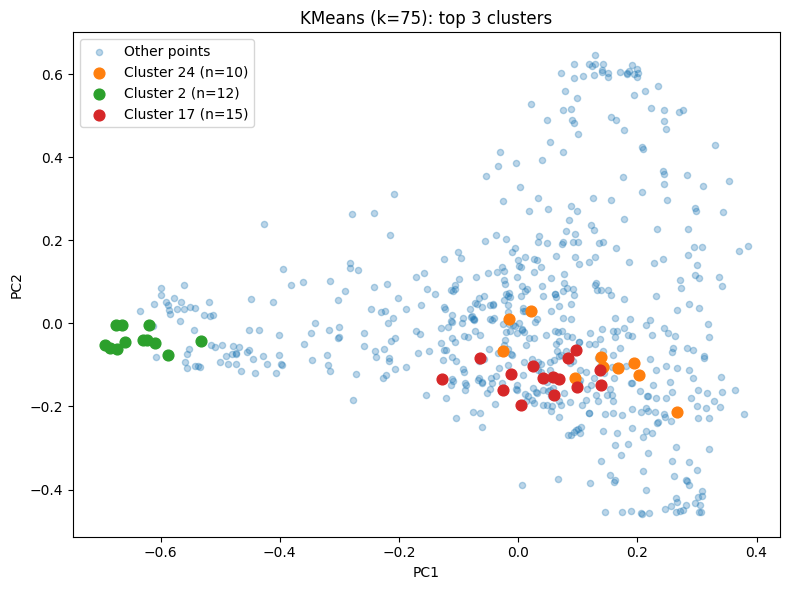

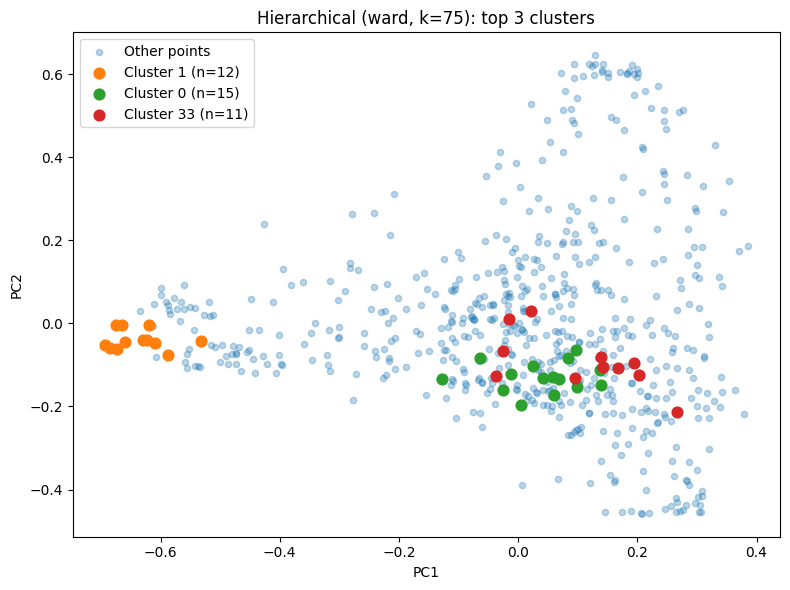

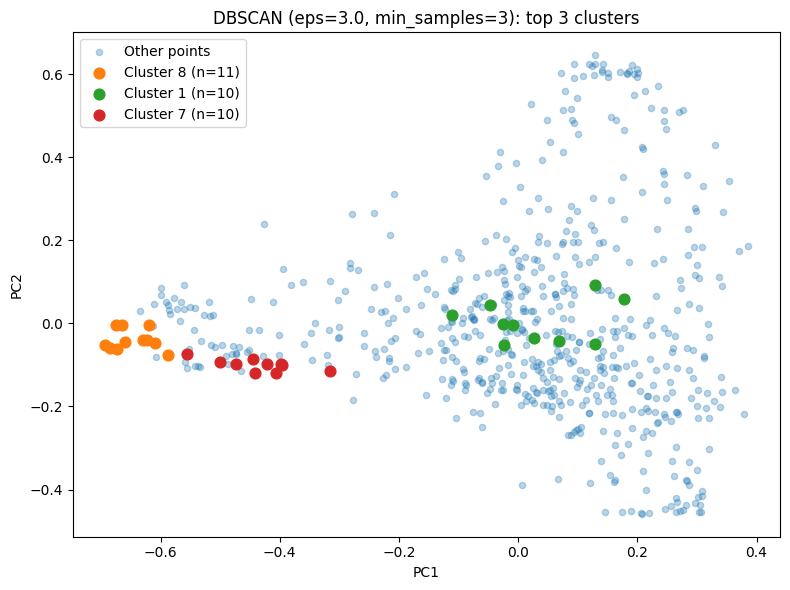

In [ ]:
def get_top_clusters(X, labels, min_size=10, top_n=3, ignore_label=None):
    """
    Compute per-cluster average silhouette and return the top_n clusters
    (by avg silhouette) with at least min_size points.
    
    Returns a DataFrame with index=cluster_label and columns:
    ['avg_sil', 'size', 'indices'] where 'indices' is a list of row indices.
    """
    labels = np.asarray(labels)
    n = len(labels)
    if n != X.shape[0]:
        raise ValueError("X and labels must have the same length")

    if ignore_label is None:
        mask = np.ones(n, dtype=bool)
    else:
        mask = labels != ignore_label

    unique_valid = np.unique(labels[mask])
    if unique_valid.size < 2:
        return pd.DataFrame(columns=["avg_sil", "size", "indices"])

    sil_values = silhouette_samples(X[mask], labels[mask])

    idx_global = np.where(mask)[0]
    df_sil = pd.DataFrame({
        "label": labels[mask],
        "silhouette": sil_values,
        "idx_global": idx_global,
    })

    cluster_stats = (
        df_sil
        .groupby("label")
        .agg(
            avg_sil=("silhouette", "mean"),
            size=("idx_global", "size"),
            indices=("idx_global", lambda x: list(x)),
        )
    )

    cluster_stats = cluster_stats[cluster_stats["size"] >= min_size]
    cluster_stats = cluster_stats.sort_values("avg_sil", ascending=False)

    return cluster_stats.head(top_n)

kmeans_top_clusters = get_top_clusters(
    X_pca_scaled,
    kmeans_best_labels,
    min_size=10,
    top_n=3
)

print("\n=== Top KMeans clusters (best k) ===")
if kmeans_top_clusters.empty:
    print("No KMeans clusters with >= 10 venues.")
else:
    for rank, (cluster_label, row) in enumerate(kmeans_top_clusters.iterrows(), start=1):
        indices = row["indices"]
        venues = venue_df.iloc[indices]["venue"].tolist()
        print(
            f"\n[KMeans #{rank}] cluster_label={cluster_label}, "
            f"n={row['size']}, avg_silhouette={row['avg_sil']:.4f}"
        )
        for v in venues:
            print("  -", v)


hier_top_clusters = get_top_clusters(
    X_pca_scaled,
    best_labels_hier,
    min_size=10,
    top_n=3
)

print("\n=== Top Hierarchical clusters (best linkage / k) ===")
if hier_top_clusters.empty:
    print("No hierarchical clusters with >= 10 venues.")
else:
    for rank, (cluster_label, row) in enumerate(hier_top_clusters.iterrows(), start=1):
        indices = row["indices"]
        venues = venue_df.iloc[indices]["venue"].tolist()
        print(
            f"\n[Hierarchical #{rank}] cluster_label={cluster_label}, "
            f"n={row['size']}, avg_silhouette={row['avg_sil']:.4f}"
        )
        for v in venues:
            print("  -", v)


dbscan_top_clusters = None
if best_db_labels is not None:
    dbscan_top_clusters = get_top_clusters(
        X_pca_scaled,
        best_db_labels,
        min_size=10,
        top_n=3,
        ignore_label=-1,
    )

    print("\n=== Top DBSCAN clusters (best eps / min_samples, ignoring noise) ===")
    if dbscan_top_clusters.empty:
        print("No DBSCAN clusters with >= 10 venues (cores only).")
    else:
        for rank, (cluster_label, row) in enumerate(dbscan_top_clusters.iterrows(), start=1):
            indices = row["indices"]
            venues = venue_df.iloc[indices]["venue"].tolist()
            print(
                f"\n[DBSCAN #{rank}] cluster_label={cluster_label}, "
                f"n={row['size']}, avg_silhouette={row['avg_sil']:.4f}"
            )
            for v in venues:
                print("  -", v)
else:
    print("\nNo suitable DBSCAN configuration was found earlier; skipping DBSCAN top-cluster analysis.")

def plot_top_clusters_2d(X_2d, labels, cluster_stats, title, ignore_label=None):
    """
    Plot all points in light gray, and highlight the clusters described
    in cluster_stats (from get_top_clusters) in different colors.
    """
    labels = np.asarray(labels)
    n = len(labels)
    if n != X_2d.shape[0]:
        raise ValueError("X_2d and labels must have the same length")

    plt.figure(figsize=(8, 6))

    plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        s=20,
        alpha=0.3,
        label="Other points",
    )

    colors = ["C0", "C1", "C2"]
    for (color, (cluster_label, row)) in zip(colors, cluster_stats.iterrows()):
        indices = row["indices"]
        plt.scatter(
            X_2d[indices, 0],
            X_2d[indices, 1],
            s=60,
            label=f"Cluster {cluster_label} (n={row['size']})",
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

if not kmeans_top_clusters.empty:
    plot_top_clusters_2d(
        X_plot_2d,
        kmeans_best_labels,
        kmeans_top_clusters,
        title=f"KMeans (k={best_k_kmeans}): top 3 clusters"
    )

if not hier_top_clusters.empty:
    plot_top_clusters_2d(
        X_plot_2d,
        best_labels_hier,
        hier_top_clusters,
        title=f"Hierarchical ({best_linkage}, k={best_k_hier}): top 3 clusters"
    )

if (best_db_labels is not None) and (dbscan_top_clusters is not None) and (not dbscan_top_clusters.empty):
    plot_top_clusters_2d(
        X_plot_2d,
        best_db_labels,
        dbscan_top_clusters[0],
        title=f"DBSCAN (eps={best_eps}, min_samples={best_min_samples}): top 3 clusters"
    )